# Libs

In [2]:
# 기본 데이터 처리 라이브러리
import pandas as pd
import numpy as np
from tqdm import tqdm
pd.set_option('display.max_columns', None)

# 로그 및 경고 처리
import logging
import warnings
warnings.filterwarnings('ignore')  # 경고 무시
import ray
import os

# 머신러닝 및 데이터 전처리 라이브러리
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, roc_auc_score
from category_encoders import TargetEncoder

# 머신러닝 알고리즘
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import Lasso, Ridge
# from catboost import CatBoostClassifier  # 사용시 주석 해제

# 데이터 불균형 처리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 지리 정보 처리 라이브러리
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, box

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc

# 한글 폰트 설정
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# DuckDB 데이터베이스 연결
import duckdb

# UDM

In [6]:
def make_pnt(df, lat,long):
    return Point(df[long],df[lat])

def assign_gid_to_points(base, target):
    '''
    base is main base GIS Like Grid, Polygon
    target is compare to base Like Point, Polygon, Linestring
    '''
    # Ensure both GeoDataFrames have the same CRS
    if base.crs != target.crs:
        target = target.to_crs(base.crs)

    # Perform a spatial join: finds which polygon each point falls into
    target_with_gid = gpd.sjoin(target, base[['geometry', 'gid']], how='left', predicate='intersects')

    # Drop any unnecessary columns that may have been added during the spatial join
    target_with_gid = target_with_gid.drop(columns=['index_right'])

    return target_with_gid

def create_monthly_grid(gdf, sido_nm=None, sig_kor_nm=None, months=12):
    """
    주어진 GeoDataFrame에서 월별로 grid 데이터를 생성하되, SIDO_NM이나 SIG_KOR_NM으로 필터링할 수 있는 함수.
    
    Args:
    - gdf: 원본 GeoDataFrame (gid, geometry, SIDO_NM, SIG_KOR_NM를 포함해야 함)
    - sido_nm: 선택적으로 필터링할 SIDO_NM List (기본값: None)
    - sig_kor_nm: 선택적으로 필터링할 SIG_KOR_NM List (기본값: None)
    - months: 월의 개수 (기본값: 12)
    
    Returns:
    - 새로운 GeoDataFrame: 각 gid에 대해 월별로 생성된 데이터프레임

    Examples:
    - 특정 SIDO_NM으로 필터링 (예: 서울특별시): 
        gn_month_grid_sido = create_monthly_grid(full_grid, sido_nm='서울특별시')
    - 특정 SIG_KOR_NM으로 필터링 (예: 종로구) : 
        gn_month_grid_sig = create_monthly_grid(full_grid, sig_kor_nm='종로구')
    - SIDO_NM과 SIG_KOR_NM 둘 다 필터링 (예: 서울특별시, 종로구) : 
        gn_month_grid_both = create_monthly_grid(full_grid, sido_nm='서울특별시', sig_kor_nm='종로구')
    """
    # SIDO_NM 필터링
    if sido_nm:
        gdf = gdf[gdf['SIDO_NM'].isin(sido_nm)]
    
    # SIG_KOR_NM 필터링
    if sig_kor_nm:
        gdf = gdf[gdf['SIG_KOR_NM'].isin(sig_kor_nm)]
    
    # 필터링 후 데이터프레임이 비어있다면 에러 처리
    if gdf.empty:
        raise ValueError("주어진 조건에 맞는 데이터가 없습니다.")
    
    rows = []
    
    # 각 row에 대해 1월부터 n월까지의 데이터를 추가
    for _, row in tqdm(gdf.iterrows(),total=gdf.shape[0]):
        for month in range(1, months + 1):
            rows.append({'gid': row['gid'], '월': month, 'geometry': row['geometry']})
    
    # 새로운 GeoDataFrame으로 변환
    monthly_grid_gdf = gpd.GeoDataFrame(rows, geometry='geometry')
    
    return monthly_grid_gdf

def categorize_time_with_rush(hour):
    if 7 <= hour < 9:
        return '출근'
    elif 9 <= hour < 12:
        return '오전'
    elif 12 <= hour < 14:
        return '점심'
    elif 14 <= hour < 18:
        return '오후'
    elif 18 <= hour < 20:
        return '퇴근'
    elif 20 <= hour < 22:
        return '저녁'
    elif 0 <= hour < 7 or hour >= 22:
        return '심야'

def laplace_smoothing(successes, total):
    '''
    라플라스 스무딩은 베이지안 보정의 한 형태로, 기본적으로 사전 확률(Prior)을 추가하여 작은 표본에 대한 왜곡을 줄입니다. 실제 관측된 값에 대해 "가상의 사건"을 추가하여 비율을 계산합니다.
    '''
    return round((successes + 1) / (total + 2),2)

## Mapping Dictionary

In [168]:
sido_grid_dict = {key : value for key, value in zip(korea_grid['gid'],korea_grid['SIDO_NM'])}
sgg_grid_dict = {key : value for key, value in zip(korea_grid['gid'],korea_grid['SIG_KOR_NM'])}

# Data Import

In [4]:
korea_grid = gpd.read_file('../../GIS/result/Korea_Grid_drop_duplicate_200m_5179.shp',crs=5179)
taas = pd.read_csv('../../../KoRoad/TAAS/교통사고DATA_2018_2023.csv',encoding='cp949')

In [7]:
# grid
base = korea_grid[korea_grid['SIDO_NM'].isin(['서울특별시','강원특별자치도'])]

# taas
sltd_acc = taas[['TAAS사고번호','요일', '주야','기상상태'] + 
     [x for x in taas.columns if any(keyword in x for keyword in ['자수', '사고내용', '발생', '좌표']) 
      and not any(keyword in x for keyword in ['발생일시', '발생년', '발생일','코드'])]]

#make point
sltd_acc['geometry'] = sltd_acc.apply(lambda x : make_pnt(x, lat='Y좌표',long='X좌표'),axis=1)

#make geodataframe
sltd_acc = gpd.GeoDataFrame(sltd_acc,geometry='geometry', crs='EPSG:4326')

#select seoul accident
target_acc = sltd_acc[sltd_acc['발생시도'].isin(['서울','강원'])]

#make taas id to str
target_acc['TAAS사고번호'] = target_acc['TAAS사고번호'].astype('str')

In [8]:
sltd_acc_with_gid = assign_gid_to_points(base = base, target = target_acc)

# GRID <- 정보 Spatial Join

## [target_grid] 서울, 강원 월별 GRID 생성

In [9]:
target_grid = create_monthly_grid(korea_grid,sido_nm=['서울특별시','강원특별자치도'])

100%|██████████| 433425/433425 [00:16<00:00, 25817.86it/s]


## 전국단위 GRID <- TAAS 사고 발생 위치 Spatial Join
- 전체 1,343,744 건 GRID GID 결합 완료
- 570건 누락(전체의 0.04%)

In [10]:
full_with_gid = assign_gid_to_points(base=korea_grid, target=sltd_acc)

In [406]:
full_with_gid['gid'].fillna(9999999,inplace=True)
full_with_gid['gid'] = full_with_gid['gid'].astype('int')

<Axes: >

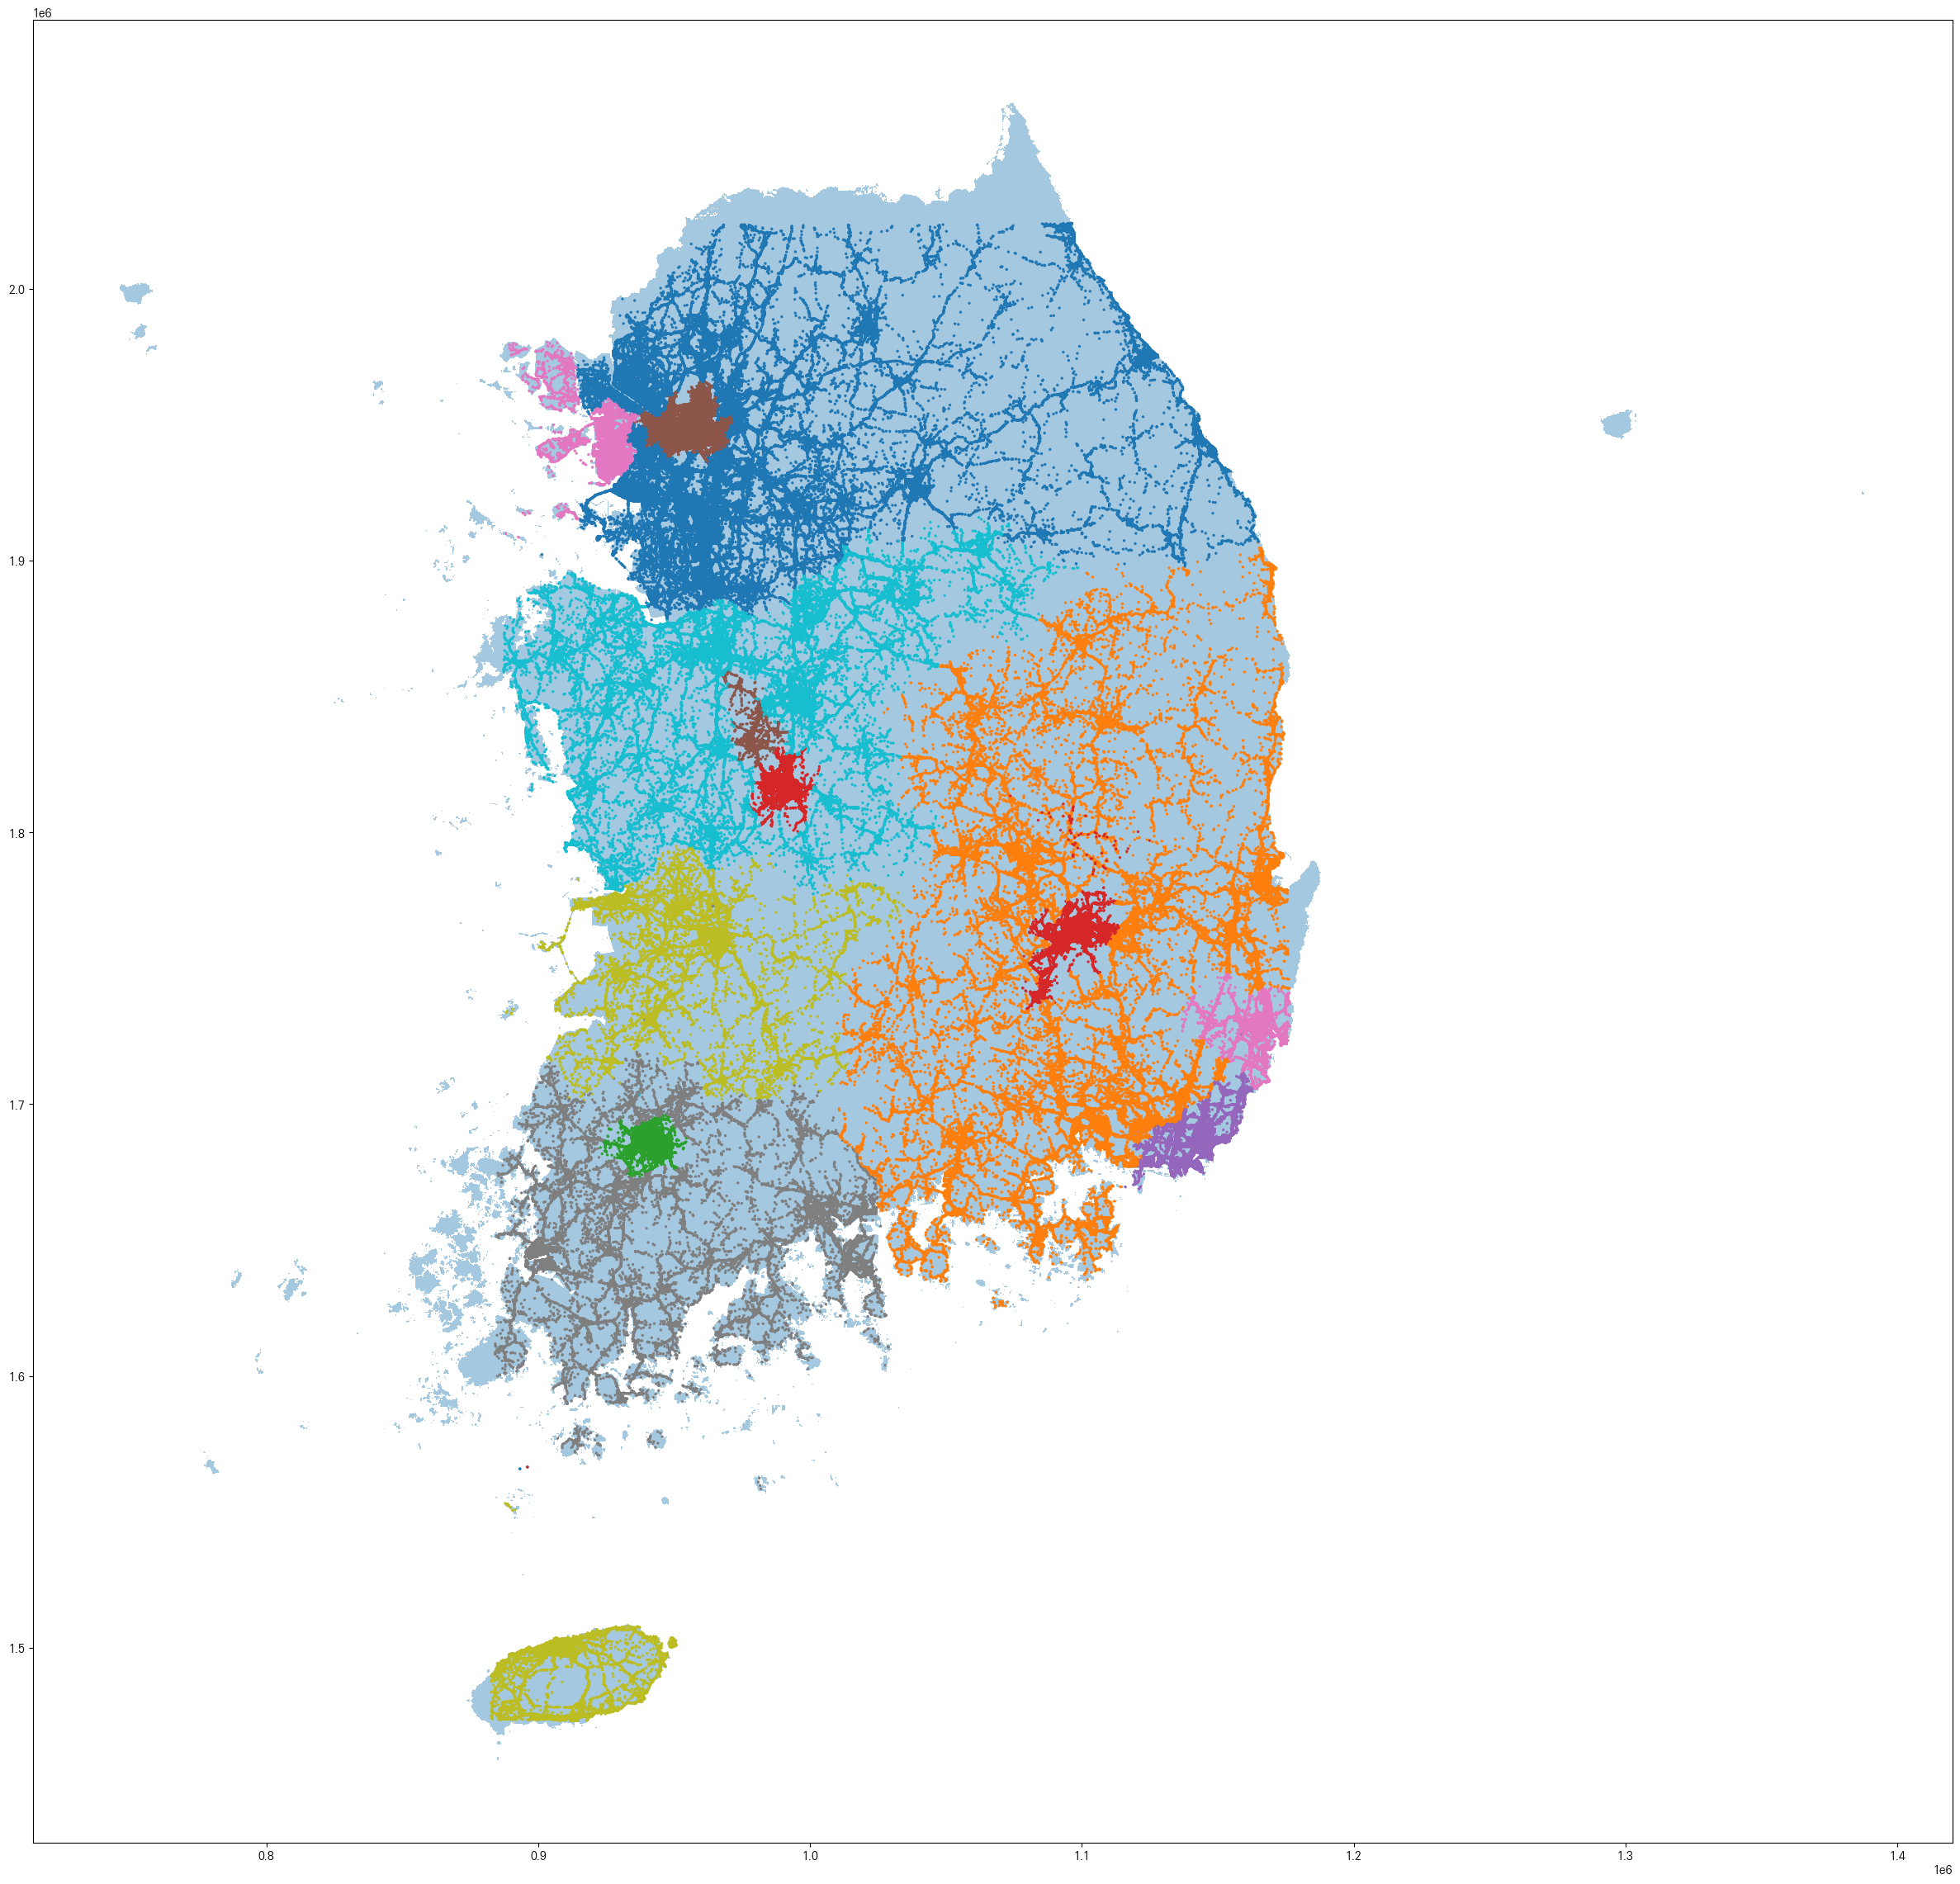

In [9]:
fig, ax = plt.subplots(figsize=(30,30))
korea_grid.plot(ax = ax , alpha=0.4)
full_with_gid[
(full_with_gid['X좌표'].between(full_with_gid['X좌표'].quantile(0.001),full_with_gid['X좌표'].quantile(0.999))) & \
(full_with_gid['Y좌표'].between(full_with_gid['Y좌표'].quantile(0.001),full_with_gid['Y좌표'].quantile(0.999)))
].plot(ax = ax , markersize=2, column ='발생시도')

## [freq_acc_area_gb] 다발지 SHP 탐색

In [11]:
path = '../../../KoRoad/TAAS/AN02_2/04_사고다발지역예측/01_서울부산_다발지역_EUCKR/'
freq_acc = gpd.GeoDataFrame()
for file in [f for f in os.listdir(path) if f.endswith('.shp')]:
    year = file.split('.')[0].split('_')[-1]
    region = file.split('.')[0].split('_')[0]
    gdf = gpd.read_file(os.path.join(path,file),crs=5179,encoding='EUC-KR')
    gdf.to_crs(5179,inplace=True)
    gdf['year'] = year
    freq_acc = pd.concat([freq_acc,gdf])

freq_acc_area = gpd.sjoin(target_grid,freq_acc,how='left',predicate='intersects')
freq_acc_area = freq_acc_area[~freq_acc_area['year'].isna()]
freq_acc_area.reset_index(drop=True,inplace=True)

freq_acc_area_gb = freq_acc_area.groupby(['gid','월'],as_index=False).agg({'year':'count',
                                        '발생건수':'sum',
                                        '사상자수':'sum',
                                        '사망자수':'sum',
                                        '중상자수':'sum',
                                        '경상자수':'sum',
                                        '부신자수':'sum',
                                       })

freq_acc_area_gb.rename(columns={'year':'다발지선정횟수',
                                 '사상자수':'다발지_사상자수',
                                 '사망자수':'다발지_사망자수',
                                 '중상자수':'다발지_중상자수',
                                 '경상자수':'다발지_경상자수',
                                 '부신자수':'다발지_부신자수'
                                },inplace=True)

## [itsc_roads_with_length] 도로정보 SHP 탐색

In [217]:
seoul_roads = gpd.read_file('../../../KoRoad/TAAS/AN02_2/04_사고다발지역예측/02_도로정보/11000/TL_SPRD_MANAGE.shp',encoding='cp949',crs=5179)
gw_roads = gpd.read_file('../../../KoRoad/TAAS/AN02_2/04_사고다발지역예측/02_도로정보/51000/TL_SPRD_MANAGE.shp',encoding='cp949',crs=5179)

roads = pd.concat([seoul_roads,gw_roads])
roads.set_crs(5179,inplace=True)
roads.reset_index(drop=True,inplace=True)
roads.reset_index(inplace=True)
roads.rename(columns={'index':'road_gid'},inplace=True)

# 도로와 격자 간의 교차 구간
itsc_roads = gpd.overlay(roads,target_grid, how='intersection')
# 교차 구간의 길이 계산
itsc_roads['length'] = itsc_roads.geometry.length

itsc_roads = itsc_roads[['road_gid','gid','length','geometry']].drop_duplicates()

itsc_roads_with_length = itsc_roads.groupby(['gid'],as_index=False).agg({'length':'sum'})

In [218]:
itsc_roads_with_length.head()

,gid,length
0,3,205.839816
1,5,49.186749
2,13,447.849351
3,14,303.185603
4,16,124.303086


## [target_acc] TAAS 집계
- TAAS 내 발생시도는 정확하지 않음

In [407]:
target_acc = full_with_gid[full_with_gid['gid'].isin(korea_grid[korea_grid['SIDO_NM'].isin(['서울특별시','강원특별자치도'])]['gid'])]

In [21]:
korea_grid[korea_grid['SIDO_NM']=='서울']['gid']
#target_grid[(target_grid['gid'].isin(korea_grid[korea_grid['SIDO_NM']=='서울']['gid']))]

Series([], Name: gid, dtype: int64)

<Axes: >

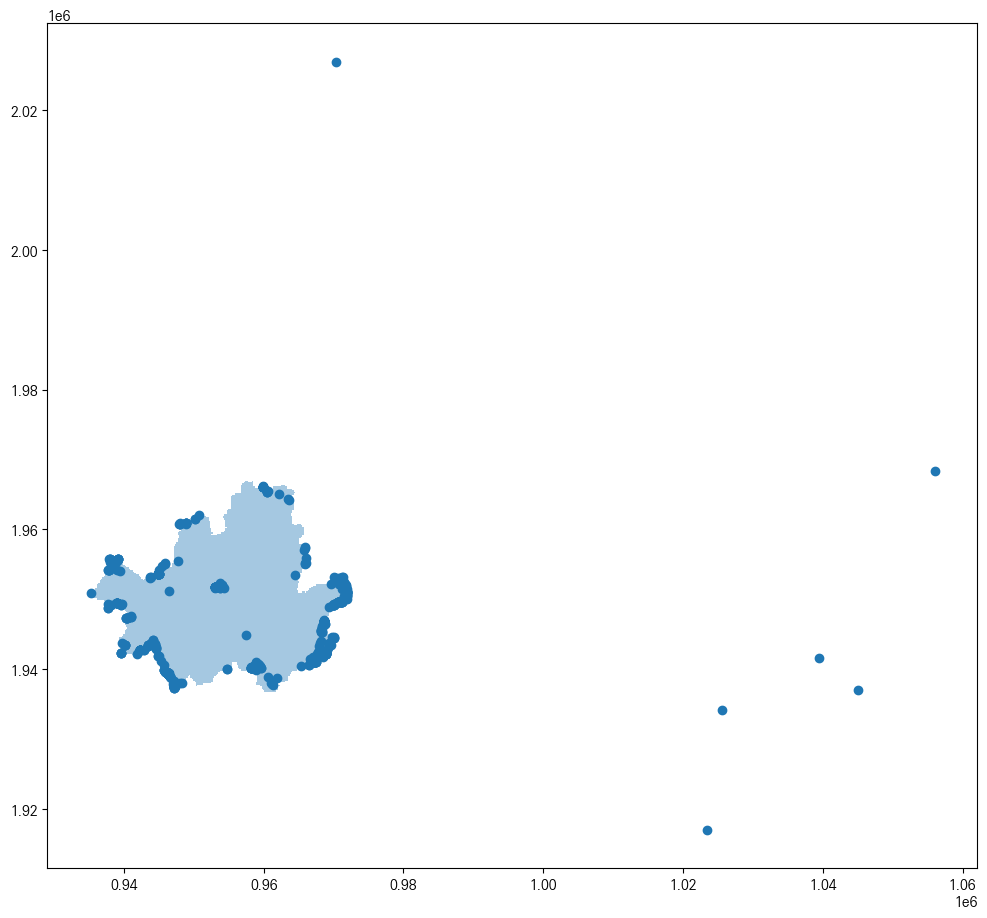

In [22]:
fig,ax = plt.subplots(figsize=(12,12))
target_grid[(target_grid['월']==1)&(target_grid['gid'].isin(korea_grid[korea_grid['SIDO_NM']=='서울특별시']['gid']))].plot(ax=ax,alpha=0.4)
target_acc[target_acc['발생시도'].isin(['경기'])].plot(ax=ax)

In [408]:
target_acc.head()

,TAAS사고번호,요일,주야,기상상태,발생월,발생시,발생시도,발생시군구,발생경찰청,발생경찰서,X좌표,Y좌표,사고내용,사망자수,중상자수,경상자수,부상신고자수,geometry,gid
0,2020010100100080,수,주,흐림,1,6,서울,중구,서울경찰청,서울중부,127.015945,37.569626,경상,0,0,2,0,POINT (957254 1952360.999),584
1,2020010100100060,수,야,맑음,1,4,서울,성북구,서울경찰청,서울성북,127.016964,37.590767,경상,0,0,1,0,POINT (957356 1954706),3398
2,2020010100100016,수,야,맑음,1,1,서울,영등포구,서울경찰청,서울영등포,126.907722,37.518198,경상,0,0,1,0,POINT (947661 1946710),10045
3,2020010100100001,수,야,맑음,1,0,서울,양천구,서울경찰청,서울양천,126.875210,37.525088,경상,0,0,1,0,POINT (944793 1947493),7826
4,2020010100100021,수,야,맑음,1,1,서울,도봉구,서울경찰청,서울도봉,127.039977,37.662975,경상,0,0,1,0,POINT (959427 1962707),4629


### 시군구 오배정 확인
- 격자와 TAAS에 기록된 시군구가 서로 다름
- 전체의 3% , 9,829건이 오배정됨
- 대부분 시군구 경계에서 발생한 오배정으로 GRID 설정과 TAAS의 정보가 다르게 나타날 수 밖에 없음
- GID는 따라가면서 행정 정보는 GID를 따라가는 것이 맞을 것으로 보임

In [219]:
tmp = pd.merge(target_acc[['gid','발생시군구','발생시도','geometry']], korea_grid[['gid','SIG_KOR_NM']], on='gid',how='left')

<Axes: >

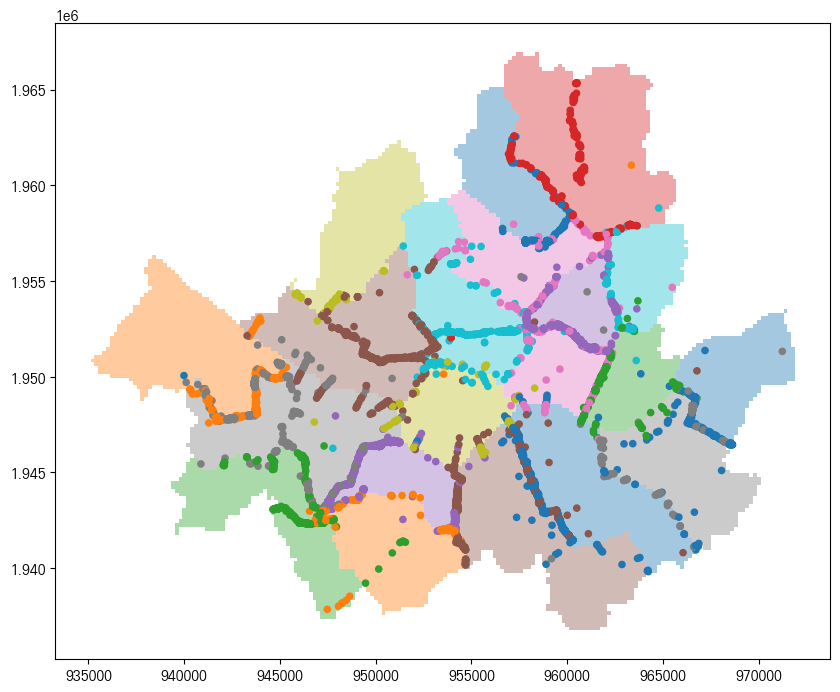

In [221]:
fig, ax = plt.subplots(figsize=(10,10))
korea_grid[korea_grid['SIDO_NM'].isin(['서울특별시'])].plot(ax = ax , alpha=0.4,column='SIG_KOR_NM')
tmp[(tmp['발생시군구'] != tmp['SIG_KOR_NM'])&(tmp['발생시도'] == '서울')].plot(ax=ax, markersize=20,column='발생시군구')

### [injury_by_gid] 사상자수 집계

In [11]:
injury_by_gid = target_acc.groupby(['gid','발생월'],as_index=False).agg({
    'TAAS사고번호' : 'count',
    '사망자수': 'sum',
    '중상자수': 'sum',
    '경상자수': 'sum',
    '부상신고자수' : 'sum'
}).rename(columns={'TAAS사고번호' : '사고건수'})

### [dayname_by_gid] 요일별 집계

In [326]:
dayname_by_gid = target_acc.groupby(['gid','발생월','요일'],as_index=False).agg({'TAAS사고번호':'count'}).pivot(index=['gid','발생월'],columns='요일',values='TAAS사고번호').reset_index()[['gid','발생월','월','화','수','목','금','토','일']].fillna(0)

dayname_by_gid['요일별발생건수_계'] = dayname_by_gid[['월', '화', '수', '목', '금', '토', '일']].sum(axis=1)
dayname_columns = ['월', '화', '수', '목', '금', '토', '일']

# 각 요일별 보정된 비율을 계산
for col in dayname_columns:
    dayname_by_gid[f'{col}_보정비율'] = dayname_by_gid.apply(lambda row: laplace_smoothing(row[col], row['요일별발생건수_계']), axis=1)

dayname_by_gid.columns = ['gid', '발생월', '월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', '요일별발생건수_계', '월_보정비율',
       '화_보정비율', '수_보정비율', '목_보정비율', '금_보정비율', '토_보정비율', '일_보정비율']
dayname_by_gid['gid'] = dayname_by_gid['gid'].astype('int')

### [time_by_gid] 시간대별 집계

In [14]:
time_by_gid = target_acc.groupby(['gid','발생월','발생시'],as_index=False).size().rename(columns={'size':'시각당발생건수'})
time_by_gid['발생시간대'] = time_by_gid['발생시'].map(categorize_time_with_rush)
time_by_gid.drop(columns=['발생시'],inplace=True)
time_by_gid = time_by_gid.pivot_table(index=['gid','발생월'],columns='발생시간대',values='시각당발생건수').reset_index().fillna(0).astype('int')

time_by_gid['시간대발생건수_계'] = time_by_gid[['심야', '오전', '오후', '저녁', '점심', '출근', '퇴근']].sum(axis=1)

time_columns = ['심야', '오전', '오후', '저녁', '점심', '출근', '퇴근']

# 각 시간대별 보정된 비율을 계산
for col in time_columns:
    time_by_gid[f'{col}_보정비율'] = time_by_gid.apply(lambda row: laplace_smoothing(row[col], row['시간대발생건수_계']), axis=1)

In [15]:
time_by_gid.head()

발생시간대,gid,발생월,심야,오전,오후,저녁,점심,출근,퇴근,시간대발생건수_계,심야_보정비율,오전_보정비율,오후_보정비율,저녁_보정비율,점심_보정비율,출근_보정비율,퇴근_보정비율
0,3,2,1,0,0,0,0,0,0,1,0.67,0.33,0.33,0.33,0.33,0.33,0.33
1,3,9,1,0,0,0,0,0,0,1,0.67,0.33,0.33,0.33,0.33,0.33,0.33
2,13,6,0,0,1,0,0,0,0,1,0.33,0.33,0.67,0.33,0.33,0.33,0.33
3,17,2,1,0,0,0,0,0,0,1,0.67,0.33,0.33,0.33,0.33,0.33,0.33
4,17,4,0,0,0,0,1,0,0,1,0.33,0.33,0.33,0.33,0.67,0.33,0.33


### [weather_by_gid] 날씨별 집계

In [409]:
weather_by_gid = target_acc.groupby(['gid','발생월','기상상태'],as_index=False).size().rename(columns={'size':'날씨당발생건수'})

In [415]:
weather_by_gid = weather_by_gid.pivot_table(index=['gid','발생월'],columns='기상상태',values='날씨당발생건수').reset_index().fillna(0).astype('int')

In [419]:
weather_by_gid['날씨당발생건수_계'] = weather_by_gid[['기타/불명', '눈', '맑음', '비', '안개', '흐림']].sum(axis=1)
weather_columns = ['기타/불명', '눈', '맑음', '비', '안개', '흐림']

# 각 날씨별 보정된 비율을 계산
for col in weather_columns:
    weather_by_gid[f'{col}_보정비율'] = weather_by_gid.apply(lambda row: laplace_smoothing(row[col], row['날씨당발생건수_계']), axis=1)

# 합쳐볼까

In [581]:
target_grid

,gid,월,geometry
0,0,1,"POLYGON ((951510.252 1958154.044, 951310.252 1..."
1,0,2,"POLYGON ((951510.252 1958154.044, 951310.252 1..."
2,0,3,"POLYGON ((951510.252 1958154.044, 951310.252 1..."
3,0,4,"POLYGON ((951510.252 1958154.044, 951310.252 1..."
4,0,5,"POLYGON ((951510.252 1958154.044, 951310.252 1..."
...,...,...,...
5201095,2543938,8,"POLYGON ((1115110.252 1991754.044, 1114910.252..."
5201096,2543938,9,"POLYGON ((1115110.252 1991754.044, 1114910.252..."
5201097,2543938,10,"POLYGON ((1115110.252 1991754.044, 1114910.252..."
5201098,2543938,11,"POLYGON ((1115110.252 1991754.044, 1114910.252..."


In [577]:
del merged_grid

In [582]:
merged_grid = pd.merge(target_grid, freq_acc_area_gb, left_on=['gid','월'], right_on=['gid','월'], how='left')
merged_grid = pd.merge(merged_grid,itsc_roads_with_length,left_on='gid',right_on='gid',how='left')
merged_grid.rename(columns={'length':'road_length'},inplace=True)
merged_grid = pd.merge(merged_grid,injury_by_gid,left_on=['gid','월'],right_on=['gid','발생월'],how='left')
merged_grid = pd.merge(merged_grid,dayname_by_gid,left_on=['gid','월'],right_on=['gid','발생월'],how='left')
merged_grid = pd.merge(merged_grid,time_by_gid,left_on=['gid','월'],right_on=['gid','발생월'],how='left')
merged_grid.drop(columns=['발생월_x','발생월_y','발생월'],inplace=True)
merged_grid = pd.merge(merged_grid,weather_by_gid,left_on=['gid','월'],right_on=['gid','발생월'],how='left')

cols = [col for col in merged_grid.columns if col != 'geometry'] + ['geometry']
merged_grid = merged_grid[cols]
merged_grid.fillna(0,inplace=True)
merged_grid.drop(columns=['발생월'],inplace=True)

In [583]:
sltd_columns = [x for x in merged_grid.columns if not any(keyword in x for keyword in ['_계','다발지_','요일','심야','오전','오후','저녁','점심','출근','퇴근','발생월','geometry'])] + ['심야_보정비율', '오전_보정비율', '오후_보정비율', '저녁_보정비율', '점심_보정비율', '출근_보정비율', '퇴근_보정비율','geometry']
sltd_df = merged_grid[sltd_columns]

# 일단 합치기 끝!

In [600]:
merged_grid.to_csv('../../../KoRoad/TAAS/AN02_2/merged_grid_data.csv', index=False, encoding='cp949')
merged_grid.to_file('../../../KoRoad/TAAS/AN02_2/merged_grid_data.shp',driver='ESRI Shapefile', index=False, encoding='cp949')

# 추가 정보 합치기...

In [471]:
target_grid = korea_grid[korea_grid['SIDO_NM'].isin(['서울특별시','강원특별자치도'])]

## [bus_stt_with_gid] 버스 정류장

In [446]:
bus_stt = pd.read_csv('../../../KoRoad/TAAS/AN02_2/국토교통부_전국 버스정류장 위치정보_20231016.csv',encoding='euc-kr')

In [487]:
seoul_gw_bus_stt = bus_stt[bus_stt['도시명'].str.contains('서울') | bus_stt['도시명'].str.contains('강원') ].reset_index(drop=True)

seoul_gw_bus_stt['geometry']=seoul_gw_bus_stt.apply(lambda x : make_pnt(x,lat='위도',long='경도'),axis=1)

seoul_gw_bus_stt = gpd.GeoDataFrame(seoul_gw_bus_stt,crs=4326,geometry='geometry')
seoul_gw_bus_stt.to_crs(5179,inplace=True)

In [490]:
bus_stt_with_gid = gpd.sjoin(seoul_gw_bus_stt,target_grid,how='left',predicate='intersects')

In [506]:
print(f'전체 수 : {bus_stt_with_gid.shape[0]}')
print(f'오류 매칭 : ', bus_stt_with_gid[bus_stt_with_gid['gid'].isna()].shape[0])
print(f'정상 매칭 : ', bus_stt_with_gid.shape[0] - bus_stt_with_gid[bus_stt_with_gid['gid'].isna()].shape[0])

전체 수 : 13199
오류 매칭 :  74
정상 매칭 :  13125


### 행정경계구역 외에 있는 데이터는 제외되었음

<Axes: >

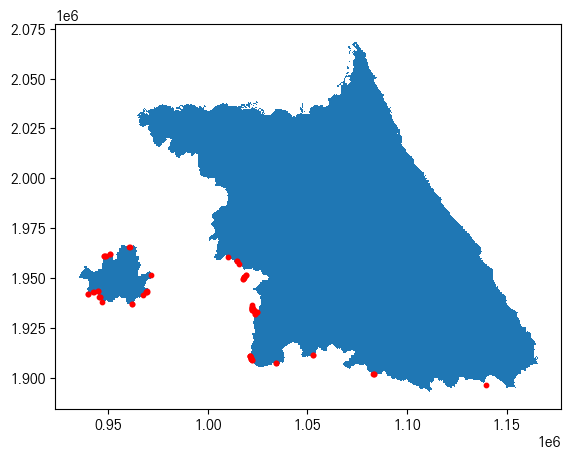

In [498]:
fig,ax = plt.subplots(figsize=(7,5))
target_grid.plot(ax=ax)
bus_stt_with_gid[bus_stt_with_gid['gid'].isna()].plot(ax=ax,markersize=10,color='red')

In [511]:
bus_stt_with_gid_gb = bus_stt_with_gid.groupby(['gid'],as_index=False).agg({'정류장번호':'count'}).astype({'gid':'int'}).rename(columns={'정류장번호':'버스정류장수'})

## [mts_with_gid_gb] 무인단속장비

In [447]:
mts = pd.read_csv('../../../KoRoad/TAAS/AN04/merge_target/교통과학장비_설치정보_241007.csv')

In [518]:
mts['geometry'] = mts.apply(lambda x : make_pnt(x,lat= '제어기 위도',long='제어기 경도'),axis=1)
mts = gpd.GeoDataFrame(mts, geometry='geometry',crs=4326)
mts.to_crs(5179, inplace=True)

In [521]:
mts_with_gid = gpd.sjoin(mts,target_grid,how='left',predicate='intersects')

#### 행정구역 경계 외 데이터 20건 제외

<Axes: >

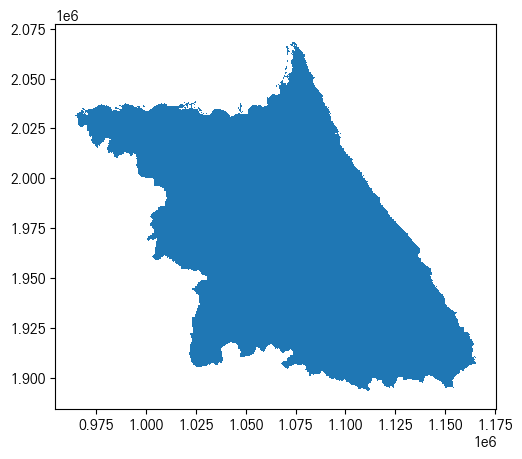

In [532]:
fig,ax = plt.subplots(figsize=(7,5))
target_grid[target_grid['SIDO_NM']=='강원특별자치도'].plot(ax=ax)
mts_with_gid[(mts_with_gid['gid'].isna())&(mts['지방청'].isin(['강원']))].plot(ax=ax,markersize=10,color='red')

In [538]:
mts_with_gid = mts_with_gid[(~mts_with_gid['gid'].isna())&(mts_with_gid['gid'].isin(korea_grid[korea_grid['SIDO_NM'].isin(['서울특별시','강원특별자치도'])]['gid']))]

In [572]:
mts_with_gid_gb = mts_with_gid.groupby(['gid','장비종류'],as_index=False).agg({'장비번호':'count'}).pivot(index='gid',columns='장비종류',values='장비번호').reset_index().fillna(0).astype('int')

## [market_with_gid_gb] 상권

In [448]:
seoul_market = pd.read_csv('../../../KoRoad/TAAS/AN02_2/소상공인시장진흥공단_상가(상권)정보_서울_202406.csv')
gw_market = pd.read_csv('../../../KoRoad/TAAS/AN02_2/소상공인시장진흥공단_상가(상권)정보_강원_202406.csv')

In [541]:
market_list = pd.concat([seoul_market,gw_market])
market_list['geometry'] = market_list.apply(lambda x : make_pnt(x,lat='위도',long='경도'),axis=1)
market_list = gpd.GeoDataFrame(market_list,crs=4326,geometry='geometry')
market_list.to_crs(5179,inplace=True)

In [543]:
market_with_gid = gpd.sjoin(market_list,target_grid,how='left',predicate='intersects')

#### 행정구역 경계 외 데이터 115건 제외

In [549]:
market_with_gid[(market_with_gid['gid'].isna())].shape[0]

115

<Axes: >

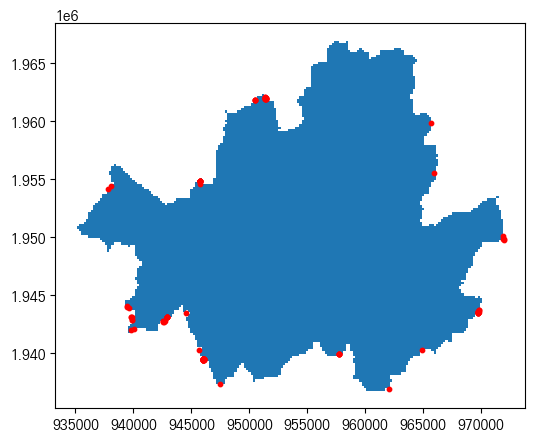

In [547]:
fig,ax = plt.subplots(figsize=(7,5))
target_grid[target_grid['SIDO_NM']=='서울특별시'].plot(ax=ax)
market_with_gid[(market_with_gid['gid'].isna())&(market_with_gid['시도명'] == '서울특별시')].plot(ax=ax,markersize=10,color='red')

In [589]:
market_with_gid_gb = market_with_gid.groupby(['gid','상권업종대분류명'],as_index=False).agg({'상가업소번호':'count'})\
.pivot(index='gid',columns='상권업종대분류명',values='상가업소번호').reset_index().fillna(0).astype('int').rename(columns={'상가업소번호':'상가수','상권업종대분류명':'상권업종'})

In [590]:
market_with_gid_gb

상권업종대분류명,gid,과학·기술,교육,보건의료,부동산,소매,수리·개인,숙박,시설관리·임대,예술·스포츠,음식
0,5,0,0,0,0,1,0,0,0,0,1
1,14,0,0,0,0,0,0,0,0,0,1
2,15,1,2,0,0,4,0,1,1,0,6
3,18,0,0,0,0,0,1,0,0,0,0
4,20,5,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
23673,2543891,0,0,0,1,0,1,1,0,0,0
23674,2543898,0,0,0,0,0,0,1,0,0,0
23675,2543930,0,0,0,0,1,0,0,0,0,1
23676,2543931,1,0,0,0,0,0,1,0,0,1


In [591]:
merged_grid = pd.merge(merged_grid,bus_stt_with_gid_gb,left_on='gid', right_on='gid', how='left')
merged_grid = pd.merge(merged_grid,mts_with_gid_gb,left_on='gid', right_on='gid', how='left')
merged_grid = pd.merge(merged_grid,market_with_gid_gb,left_on='gid', right_on='gid', how='left')

In [599]:
merged_grid.fillna({
    '버스정류장수' : 0, 
    '속도위반' : 0, 
    '신호위반' : 0, 
    '과학·기술' : 0, 
    '교육' : 0, 
    '보건의료' : 0, 
    '부동산' : 0, 
    '소매' : 0, 
    '수리·개인' : 0,
    '숙박' : 0, 
    '시설관리·임대' : 0,
    '예술·스포츠' : 0, 
    '음식' : 0
},inplace=True)

In [601]:
merged_grid

,gid,월,다발지선정횟수,발생건수,다발지_사상자수,다발지_사망자수,다발지_중상자수,다발지_경상자수,다발지_부신자수,road_length,사고건수,사망자수,중상자수,경상자수,부상신고자수,월요일,화요일,수요일,목요일,금요일,토요일,일요일,요일별발생건수_계,월_보정비율,화_보정비율,수_보정비율,목_보정비율,금_보정비율,토_보정비율,일_보정비율,심야,오전,오후,저녁,점심,출근,퇴근,시간대발생건수_계,심야_보정비율,오전_보정비율,오후_보정비율,저녁_보정비율,점심_보정비율,출근_보정비율,퇴근_보정비율,기타/불명,눈,맑음,비,안개,흐림,날씨당발생건수_계,기타/불명_보정비율,눈_보정비율,맑음_보정비율,비_보정비율,안개_보정비율,흐림_보정비율,geometry,버스정류장수,속도위반,신호위반,과학·기술,교육,보건의료,부동산,소매,수리·개인,숙박,시설관리·임대,예술·스포츠,음식
0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((951510.252 1958154.044, 951310.252 1...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((951510.252 1958154.044, 951310.252 1...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((951510.252 1958154.044, 951310.252 1...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((951510.252 1958154.044, 951310.252 1...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((951510.252 1958154.044, 951310.252 1...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5201095,2543938,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((1115110.252 1991754.044, 1114910.252...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5201096,2543938,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((1115110.252 1991754.044, 1114910.252...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5201097,2543938,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((1115110.252 1991754.044, 1114910.252...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5201098,2543938,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((1115110.252 1991754.044, 1114910.252...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
